In [ ]:
##Import required libraries and packages

import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sb
from tqdm import tqdm

import torchvision
import torch.nn.functional as F
from torch.nn import init
import torchvision.transforms as Tranforms
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torch.nn as nn
import matplotlib.gridspec as gridspec
from IPython.display import clear_output
%matplotlib inline

torch.set_default_device("cuda")

In [ ]:
##Mount Google Drive to store tensors

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
if torch.cuda.is_available(): 
  torch.set_default_device("cuda")
  device = 'cuda'
else:
  torch.set_default_device("cpu")
  device = 'cpu'

print(device)

cuda


In [ ]:

import torchvision
import torchvision.datasets as data
import torchvision.transforms as Transforms

Tflatten = Transforms.Lambda(lambda x: torch.flatten(x))
Tcuda = Transforms.Lambda(lambda x: x.to("cuda"))
Tfloat = Transforms.Lambda(lambda x: x.to(torch.float))

T = Transforms.Compose([Transforms.ToTensor(), Tfloat, Tflatten, Tcuda])
cifar_train = data.CIFAR10("./", train = True, download = True, transform=T)
cifar_dataloader = torch.utils.data.DataLoader(cifar_train)
print("CIFAR:", next(iter(cifar_dataloader))[0].shape)
print("CIFAR:", cifar_train.data.shape)

T = Transforms.Compose([Transforms.ToTensor(), Tfloat, Transforms.Normalize(mean = [0,0,0], std = [5,5,5]), Tflatten, Tcuda])
cifar_test = data.CIFAR10("./", train = False, download = True, transform=T)
cifar_dataloader = torch.utils.data.DataLoader(cifar_test)
print("CIFAR:", next(iter(cifar_dataloader))[0].shape)
print("CIFAR:", cifar_test.data.shape)

T = Transforms.Compose([Transforms.ToTensor(), Transforms.Resize((32,32)), Tfloat, Transforms.Normalize(mean = [0,0,0], std = [5,5,5]), Tflatten, Tcuda])
stl10_train = data.STL10("./", split = 'train', download = True, transform=T)
stl10_dataloader = torch.utils.data.DataLoader(stl10_train)
print("STL10:", next(iter(stl10_dataloader))[0].shape)
print("STL10:", stl10_train.data.shape)


T = Transforms.Compose([Transforms.ToTensor(), Tfloat, Transforms.Normalize(mean = [0,0,0], std = [5,5,5]), Tflatten, Tcuda])
svhn_train = data.SVHN("./", split = 'train', download = True, transform=T)
svhn_dataloader = torch.utils.data.DataLoader(svhn_train)
print("SVHN:", next(iter(svhn_dataloader))[0].shape)
print("SVHN:", svhn_train.data.shape)


100%|██████████| 170498071/170498071 [00:13<00:00, 12223906.71it/s]


Extracting ./cifar-10-python.tar.gz to ./
CIFAR: torch.Size([1, 3072])
CIFAR: (50000, 32, 32, 3)
Files already downloaded and verified
CIFAR: torch.Size([1, 3072])
CIFAR: (10000, 32, 32, 3)


100%|██████████| 2640397119/2640397119 [02:46<00:00, 15836154.25it/s]


Extracting ./stl10_binary.tar.gz to ./


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


STL10: torch.Size([1, 3072])
STL10: (5000, 3, 96, 96)


100%|██████████| 182040794/182040794 [00:15<00:00, 11802797.68it/s]


SVHN: torch.Size([1, 3072])
SVHN: (73257, 3, 32, 32)


In [ ]:
T = Transforms.Compose([Transforms.ToTensor(), Transforms.Resize((32,32)), Tfloat, Transforms.Normalize(mean = [0,0,0], std = [5,5,5]), Tflatten, Tcuda])
stl10_test = data.STL10("./", split = 'test', download = True, transform=T)
stl10_dataloader = torch.utils.data.DataLoader(stl10_test)
print("STL10:", next(iter(stl10_dataloader))[0].shape)
print("STL10:", stl10_test.data.shape)

Files already downloaded and verified
STL10: torch.Size([1, 3072])
STL10: (8000, 3, 96, 96)


In [ ]:
def eigen_squared(cr, z):
  num = z * cr ** 2 + cr ** 2 + z * cr - 2*cr + 1
  den = 2*z**2*cr * np.sqrt(4*z*cr**2 + (1-cr + cr*z)**2)
  return num/den + (1-1/cr)/(2*z**2)

def scale(cr,z):
  return 0.5 + (1+z*cr-np.sqrt(4*z*cr**2 + (1-cr + cr*z)**2))/(2*cr)

def scale_squared(cr,z):
  return -0.5 + (1+cr+z*cr)/(2*np.sqrt(4*z*cr**2 + (1-cr + cr*z)**2))

def scale_both_squared(cr,z):
  return scale(cr,z) - z*scale_squared(cr,z)

def var(c,r,d,N):
  cr = r/N
  if c < 1:
    return r * (scale_both_squared(cr, 1/c) + scale_squared(cr,1/c))/(d*(1-c))
  else:
    return r * c * scale(cr,1) / (d*(c-1))

def calc_gen_error_new(M,ntrn,c,ntst,r,S1,L):
  gen_error = 0
  if c<1:
    gen_error += (torch.diag(1/(1+S1**2*c)) @ L).square().sum()/L.shape[1]
  if c>1:
    gen_error += (torch.diag(1/(1+S1**2)) @ L).square().sum()/L.shape[1]

  return gen_error + var(c,r,M,ntrn)

# Cov might need to be diagonal....
def calc_gen_error_new_new(M,ntrn,c,ntst,r,S1,Cov):
  gen_error = 0
  if c<1:
    gen_error += eigen_squared(r/ntrn, 1/c) * (Cov).square().sum()/(c**2)
  if c>1:
    gen_error += eigen_squared(r/ntrn, 1) * (Cov).square().sum()

  return gen_error + var(c,r,M,ntrn)

def calc_gen_error(M,ntrn,c,ntst,r,S1,L):
  gen_error = 0
  if c<1:
    gen_error += (torch.diag(1/(1+S1**2*c)) @ L).square().sum()/L.shape[1]
  if c>1:
    gen_error += (torch.diag(1/(1+S1**2)) @ L).square().sum()/L.shape[1]
  
  gen_error += calc_wnorm(c,r,S1)/M

  return gen_error 

def calc_gen_error_regression(M,ntrn,c,ntst,r,S1,L,betahat):
  gen_error = 0
  if c<1:
    gen_error += (betahat.T @ torch.diag(1/(1+S1**2*c)) @ L).square().sum()/L.shape[1]
  if c>1:
    gen_error += (betahat.T @ torch.diag(1/(1+S1**2)) @ L).square().sum()/L.shape[1]
  
  gen_error += calc_wnorm_regression(c,r,S1,betahat)/M

  return gen_error 

def calc_lower_bound(M,ntrn,c,ntst,r,S1,L,alpha):
  wnorm_root = calc_wnorm(c,r,S1).sqrt()
  if c<1:
    bias = (torch.diag(1/(1+S1**2*c)) @ L).square().sum().sqrt()
  if c>1:
    bias = (torch.diag(1/(1+S1**2)) @ L).square().sum().sqrt()
  
  bias = (bias-alpha*(wnorm_root+1))**2/L.shape[0]

  return bias + wnorm_root.square()/M

def calc_upper_bound(M,ntrn,c,ntst,r,S1,L,alpha):
  wnorm_root = calc_wnorm(c,r,S1).sqrt()
  if c<1:
    bias = (torch.diag(1/(1+S1**2*c)) @ L).square().sum().sqrt()
  if c>1:
    bias = (torch.diag(1/(1+S1**2)) @  L).square().sum().sqrt()
  
  bias = (bias+alpha*(wnorm_root+1))**2/L.shape[0]

  return bias + wnorm_root.square()/M

def calc_W_minus_I_norm(c,r,S1,M):
  wnorm = 0
  if c<1:
    for i in range(1):
      wnorm = wnorm +  (((c**2*(S1[i]**2 + S1[i]**4))/((1+S1[i]**2*c)**2*(1-c))).sqrt()+1)**2
  if c>1:
    for i in range(1):
      wnorm = wnorm +  (((c*S1[i]**2)/((1+S1[i]**2)*(c-1))).sqrt()+1).square()
  return wnorm

def calc_wnorm(c,r,S1):
  wnorm = 0
  if c<1:
    for i in range(r):
      wnorm = wnorm +  ((S1[i]**2 + S1[i]**4))/((1/c+S1[i]**2)**2*(1-c))
  if c>1:
    for i in range(r):
      wnorm = wnorm +  (c*S1[i]**2)/((1+S1[i]**2)*(c-1))

  return wnorm 

def calc_wnorm_regression(c,r,S1,betahat):
  wnorm = 0
  if c<1:
    for i in range(r):
      wnorm = wnorm +  betahat[i,0]**2 * (c**2*(S1[i]**2 + S1[i]**4))/((1+S1[i]**2*c)**2*(1-c))
  if c>1:
    for i in range(r):
      wnorm = wnorm +  betahat[i,0]**2 * (c*S1[i]**2)/((1+S1[i]**2)*(c-1))

  return wnorm

In [ ]:
path1_rank = F"/content/drive/MyDrive/Denoising/dataRanks/"
path2_rank = F"/content/drive/MyDrive/Denoising/dataRanks/"

In [ ]:
##store more r values for pcr in subspace, out of subspace for small alpha, linear regression, iid test 

from numpy.lib.arraysetops import setxor1d
## Low SNR error 

M = 3072
N = torch.arange(1050,10500,550).to(torch.int)
#N = torch.arange(7100,10500,550).to(torch.int)
#r_values = [1,2,3,5,10,20,50,100,150,200,250]
# r_values = [50]
r_values = [50,100]

#r_values = [100]
# N = torch.arange(500,1000,500)
# r_values = [1,100]
Ntst = 2500

##pcr in subspace
Err_stl10 = torch.zeros(len(r_values),N.shape[0]).to(device) #theoretical error
Err_emp_stl10 = torch.zeros(len(r_values),N.shape[0]).to(device) #emperical error 

Err_svhn = torch.zeros(len(r_values),N.shape[0]).to(device) #theoretical error
Err_emp_svhn = torch.zeros(len(r_values),N.shape[0]).to(device) #emperical error 

Err_cifar = torch.zeros(len(r_values),N.shape[0]).to(device) #theoretical error
Err_emp_cifar = torch.zeros(len(r_values),N.shape[0]).to(device) #emperical error 

##pcr out of subspace at alpha = 0.1 


alpha_cifar = 0.1*torch.ones(len(r_values),N.shape[0]).to(device)
alpha_stl10 = 0.1*torch.ones(len(r_values),N.shape[0]).to(device)
alpha_svhn = 0.1*torch.ones(len(r_values),N.shape[0]).to(device)

Err_stl10_bound = torch.zeros(len(r_values),N.shape[0]).to(device) #theoretical error
Err_stl10_alpha = torch.zeros(len(r_values),N.shape[0]).to(device) #theoretical error
Err_emp_stl10_alpha = torch.zeros(len(r_values),N.shape[0]).to(device) #emperical error 

Err_svhn_alpha = torch.zeros(len(r_values),N.shape[0]).to(device) #theoretical error
Err_svhn_bound = torch.zeros(len(r_values),N.shape[0]).to(device) #theoretical error
Err_emp_svhn_alpha = torch.zeros(len(r_values),N.shape[0]).to(device) #emperical error 

Err_cifar_bound = torch.zeros(len(r_values),N.shape[0]).to(device) #theoretical error
Err_cifar_alpha = torch.zeros(len(r_values),N.shape[0]).to(device) #theoretical error
Err_emp_cifar_alpha = torch.zeros(len(r_values),N.shape[0]).to(device) #emperical error 

##pcr out of subspace (outss)
Err_stl10_bound_outss = torch.zeros(len(r_values),N.shape[0]).to(device) #theoretical bound
Err_stl10_outss = torch.zeros(len(r_values),N.shape[0]).to(device) #theoretical error
Err_emp_stl10_outss = torch.zeros(len(r_values),N.shape[0]).to(device) #emperical error 

Err_svhn_outss = torch.zeros(len(r_values),N.shape[0]).to(device) #theoretical error
Err_svhn_bound_outss = torch.zeros(len(r_values),N.shape[0]).to(device) #theoretical error
Err_emp_svhn_outss = torch.zeros(len(r_values),N.shape[0]).to(device) #emperical error 

Err_cifar_bound_outss = torch.zeros(len(r_values),N.shape[0]).to(device) #theoretical error
Err_cifar_outss = torch.zeros(len(r_values),N.shape[0]).to(device) #theoretical error
Err_emp_cifar_outss = torch.zeros(len(r_values),N.shape[0]).to(device) #emperical error 


##iid-test data 


Err_iid_test = torch.zeros(len(r_values),N.shape[0]).to(device) #theoretical error
Err_emp_iid_test = torch.zeros(len(r_values),N.shape[0]).to(device) #emperical error 

##linear regression
Err_stl10_reg = torch.zeros(len(r_values),N.shape[0]).to(device) #theoretical error
Err_emp_stl10_reg = torch.zeros(len(r_values),N.shape[0]).to(device) #emperical error 

Err_svhn_reg = torch.zeros(len(r_values),N.shape[0]).to(device) #theoretical error
Err_emp_svhn_reg = torch.zeros(len(r_values),N.shape[0]).to(device) #emperical error 

Err_cifar_reg = torch.zeros(len(r_values),N.shape[0]).to(device) #theoretical error
Err_emp_cifar_reg = torch.zeros(len(r_values),N.shape[0]).to(device) #emperical error 

beta = torch.randn(M,1)
beta /= torch.norm(beta)

T = 200 #Number of runs

for i,r in list(enumerate(r_values)):
  print(r)
  for j in range(N.shape[0]):
    c = M/N[j]
    cifar_train_data = torch.utils.data.DataLoader(cifar_train, batch_size = N[j].item(), shuffle = False)
    Xtrn = next(iter(cifar_train_data))[0].T

    cifar_test_data = torch.utils.data.DataLoader(cifar_test, batch_size = Ntst, shuffle = False)
    Xtst_cifar = next(iter(cifar_test_data))[0].T

    stl10_data = torch.utils.data.DataLoader(stl10_train, batch_size = Ntst, shuffle = False)
    Xtst_stl10 = next(iter(stl10_data))[0].T

    svhn_data = torch.utils.data.DataLoader(svhn_train, batch_size = Ntst, shuffle = False)
    Xtst_svhn = next(iter(svhn_data))[0].T

    print(Xtrn.shape, Xtst_cifar.shape)

    print(c)
    U,S,Vh = torch.linalg.svd(Xtrn)
    Xtrn = U[:,:r] @ torch.diag(S[:r]) @ Vh[:r,:]

    P = U[:,:r] @ U[:,:r].T

    Xtst_cifar_proj = P @ Xtst_cifar
    Xtst_stl10_proj = P @ Xtst_stl10
    Xtst_svhn_proj = P @ Xtst_svhn

    L_cifar = U[:,:r].T @ Xtst_cifar
    L_stl10 = U[:,:r].T @ Xtst_stl10
    L_svhn = U[:,:r].T @ Xtst_svhn

    ##pcr in subspace 
    # Err_cifar[i,j] = calc_gen_error(M,N[j],c,Ntst,r,S[:r],L_cifar)
    # Err_stl10[i,j] = calc_gen_error(M,N[j],c,Ntst,r,S[:r],L_stl10)
    # Err_svhn[i,j] = calc_gen_error(M,N[j],c,Ntst,r,S[:r],L_svhn)

    ##pcr out of subspace for alpha = 0.1
    # Xtst_cifar_alpha = Xtst_cifar_proj + 0.1*torch.randn_like(Xtst_cifar)/np.sqrt(M*Ntst)
    # Xtst_stl10_alpha = Xtst_stl10_proj + 0.1*torch.randn_like(Xtst_stl10)/np.sqrt(M*Ntst)
    # Xtst_svhn_alpha = Xtst_svhn_proj + 0.1*torch.randn_like(Xtst_svhn)/np.sqrt(M*Ntst)

    # Err_cifar_bound[i,j] = alpha_cifar[i,j]**2 * calc_W_minus_I_norm(c,r,S[:r],M)/Ntst
    # Err_stl10_bound[i,j] = alpha_stl10[i,j]**2 * calc_W_minus_I_norm(c,r,S[:r],M)/Ntst
    # Err_svhn_bound[i,j] = alpha_svhn[i,j]**2 * calc_W_minus_I_norm(c,r,S[:r],M)/Ntst

    # Err_cifar_alpha[i,j] = calc_gen_error(M,N[j],c,Ntst,r,S[:r],L_cifar)
    # Err_stl10_alpha[i,j] = calc_gen_error(M,N[j],c,Ntst,r,S[:r],L_stl10)
    # Err_svhn_alpha[i,j] = calc_gen_error(M,N[j],c,Ntst,r,S[:r],L_svhn)

    ## pcr out of subspace for large alpha
    alpha_cifar[i,j] = (Xtst_cifar_proj - Xtst_cifar).square().sum().sqrt()
    alpha_stl10[i,j] = (Xtst_stl10_proj - Xtst_stl10).square().sum().sqrt()
    alpha_svhn[i,j] = (Xtst_svhn_proj - Xtst_svhn).square().sum().sqrt()

    # Err_cifar_bound_outss[i,j] = alpha_cifar[i,j]**2 * calc_W_minus_I_norm(c,r,S[:r],M)/Ntst
    # Err_stl10_bound_outss[i,j] = alpha_stl10[i,j]**2 * calc_W_minus_I_norm(c,r,S[:r],M)/Ntst
    # Err_svhn_bound_outss[i,j] = alpha_svhn[i,j]**2 * calc_W_minus_I_norm(c,r,S[:r],M)/Ntst

    # Err_cifar_outss[i,j] = calc_gen_error(M,N[j],c,Ntst,r,S[:r],L_cifar)
    # Err_stl10_outss[i,j] = calc_gen_error(M,N[j],c,Ntst,r,S[:r],L_stl10)
    # Err_svhn_outss[i,j] = calc_gen_error(M,N[j],c,Ntst,r,S[:r],L_svhn)


    # ##iid test data
    # Cov_root = torch.randn(r,r)/np.sqrt(r)

    # L = Cov_root @ torch.randn(r,Ntst)/np.sqrt(r)
    # Ul, Sl, _ = torch.linalg.svd(L)

    # Xtst = U[:,:r] @ L

    # Err_iid_test[i,j] = calc_gen_error(M,N[j],c,Ntst,r,S[:r],Cov_root @ torch.eye(r)*np.sqrt(Ntst/r))

    # ##linear regression 
    # betahat = (beta.T @ U[:,:r]).T

    # Err_cifar_reg[i,j] = calc_gen_error_regression(M,N[j],c,Ntst,r,S[:r],L_cifar, betahat)
    # Err_stl10_reg[i,j] = calc_gen_error_regression(M,N[j],c,Ntst,r,S[:r],L_stl10, betahat)
    # Err_svhn_reg[i,j] = calc_gen_error_regression(M,N[j],c,Ntst,r,S[:r],L_svhn, betahat)

    # for k in tqdm(range(T)):
    #     Atrn = torch.randn_like(Xtrn)/np.sqrt(M)
    #     W = Xtrn.mm(torch.pinverse(Xtrn+Atrn))

    #     ## PCR in subspace 

    #     Atst_cifar = torch.randn_like(Xtst_cifar_proj)/np.sqrt(M)
    #     Yp = W.mm(Xtst_cifar_proj + Atst_cifar)
    #     Err_emp_cifar[i,j] += (Xtst_cifar_proj - Yp).square().sum()/(T*Ntst)

    #     Atst_stl10 = torch.randn_like(Xtst_stl10_proj)/np.sqrt(M)
    #     Yp = W.mm(Xtst_stl10_proj + Atst_stl10)
    #     Err_emp_stl10[i,j] += (Xtst_stl10_proj - Yp).square().sum()/(T*Ntst)

    #     Atst_svhn = torch.randn_like(Xtst_svhn_proj)/np.sqrt(M)
    #     Yp = W.mm(Xtst_svhn_proj + Atst_svhn)
    #     Err_emp_svhn[i,j] += (Xtst_svhn_proj - Yp).square().sum()/(T*Ntst)

    #     ##pcr out of subspace at alpha = 0.1 
    #     Atst_cifar = torch.randn_like(Xtst_cifar_proj)/np.sqrt(M)
    #     Yp = W.mm(Xtst_cifar_alpha + Atst_cifar)
    #     Err_emp_cifar_alpha[i,j] += (Xtst_cifar_alpha - Yp).square().sum()/(T*Ntst)

    #     Atst_stl10 = torch.randn_like(Xtst_stl10_proj)/np.sqrt(M)
    #     Yp = W.mm(Xtst_stl10_alpha + Atst_stl10)
    #     Err_emp_stl10_alpha[i,j] += (Xtst_stl10_alpha - Yp).square().sum()/(T*Ntst)

    #     Atst_svhn = torch.randn_like(Xtst_svhn_proj)/np.sqrt(M)
    #     Yp = W.mm(Xtst_svhn_alpha + Atst_svhn)
    #     Err_emp_svhn_alpha[i,j] += (Xtst_svhn_alpha - Yp).square().sum()/(T*Ntst)

    #     ##pcr out of subspace for large alpha
    #     Atst_cifar = torch.randn_like(Xtst_cifar)/np.sqrt(M)
    #     Yp = W.mm(Xtst_cifar + Atst_cifar)
    #     Err_emp_cifar_outss[i,j] += (Xtst_cifar - Yp).square().sum()/(T*Ntst)

    #     Atst_stl10 = torch.randn_like(Xtst_stl10_proj)/np.sqrt(M)
    #     Yp = W.mm(Xtst_stl10 + Atst_stl10)
    #     Err_emp_stl10_outss[i,j] += (Xtst_stl10 - Yp).square().sum()/(T*Ntst)

    #     Atst_svhn = torch.randn_like(Xtst_svhn_proj)/np.sqrt(M)
    #     Yp = W.mm(Xtst_svhn + Atst_svhn)
    #     Err_emp_svhn_outss[i,j] += (Xtst_svhn - Yp).square().sum()/(T*Ntst)

    #     ##iid test data
    #     Atst = torch.randn_like(Xtst)/np.sqrt(M)
    #     Yp = W.mm(Xtst + Atst)
    #     Err_emp_iid_test[i,j] += (Xtst - Yp).square().sum()/(T*Ntst)

    #     ##linear regression
    #     W = beta.T @ W
    #     Atst_cifar = torch.randn_like(Xtst_cifar_proj)/np.sqrt(M)
    #     Yp = W.mm(Xtst_cifar_proj + Atst_cifar)
    #     Err_emp_cifar_reg[i,j] += (beta.T @ Xtst_cifar_proj - Yp).square().sum()/(T*Ntst)

    #     Atst_stl10 = torch.randn_like(Xtst_stl10_proj)/np.sqrt(M)
    #     Yp = W.mm(Xtst_stl10_proj + Atst_stl10)
    #     Err_emp_stl10_reg[i,j] += (beta.T @ Xtst_stl10_proj - Yp).square().sum()/(T*Ntst)

    #     Atst_svhn = torch.randn_like(Xtst_svhn_proj)/np.sqrt(M)
    #     Yp = W.mm(Xtst_svhn_proj + Atst_svhn)
    #     Err_emp_svhn_reg[i,j] += (beta.T @ Xtst_svhn_proj - Yp).square().sum()/(T*Ntst)

    # # print(wnorm, bias)
    # # print(emp_norm, emp_bias)
    
    # # print((Err_emp_cifar[i,j]-Err_cifar[i,j]).abs()/Err_emp_cifar[i,j])
    # # print((Err_emp_stl10[i,j]-Err_stl10[i,j]).abs()/Err_emp_stl10[i,j])
    # # print((Err_emp_svhn[i,j]-Err_svhn[i,j]).abs()/Err_emp_svhn[i,j])

    # # torch.save(Err_emp_cifar,path2_rank+"cifar-emp-ranks.pt")
    # # torch.save(Err_cifar,path1_rank+"cifar-ranks.pt")  
    # # torch.save(Err_emp_stl10,path2_rank+"stl10-emp-ranks.pt")
    # # torch.save(Err_stl10,path1_rank+"stl10-ranks.pt")  
    # # torch.save(Err_emp_svhn,path2_rank+"svhn-emp-ranks.pt")
    # # torch.save(Err_svhn,path1_rank+"svhn-ranks.pt")    

    # # torch.save(Err_emp_cifar_alpha,path2_rank+"cifar-emp-alpha-ranks.pt")
    # # torch.save(Err_cifar_alpha,path1_rank+"cifar-alpha-ranks.pt")  
    # # torch.save(Err_cifar_bound,path1_rank+"cifar-bound-ranks.pt")  
    # # torch.save(Err_emp_stl10_alpha,path2_rank+"stl10-emp-alpha-ranks.pt")
    # # torch.save(Err_stl10_alpha,path1_rank+"stl10-alpha-ranks.pt")  
    # # torch.save(Err_stl10_bound,path1_rank+"stl10-bound-ranks.pt")  
    # # torch.save(Err_emp_svhn_alpha,path2_rank+"svhn-emp-alpha-ranks.pt")
    # # torch.save(Err_svhn_alpha,path1_rank+"svhn-alpha-ranks.pt")  
    # # torch.save(Err_svhn_bound,path1_rank+"svhn-bound-ranks.pt")   

    # # torch.save(Err_emp_cifar_outss,path2_rank+"cifar-emp-outss-ranks.pt")
    # # torch.save(Err_cifar_outss,path1_rank+"cifar-outss-ranks.pt")  
    # # torch.save(Err_cifar_bound_outss,path1_rank+"cifar-bound-outss-ranks.pt")  
    # # torch.save(Err_emp_stl10_outss,path2_rank+"stl10-emp-outss-ranks.pt")
    # # torch.save(Err_stl10_outss,path1_rank+"stl10-outss-ranks.pt")  
    # # torch.save(Err_stl10_bound_outss,path1_rank+"stl10-bound-outss-ranks.pt")  
    # # torch.save(Err_emp_svhn_outss,path2_rank+"svhn-emp-outss-ranks.pt")
    # # torch.save(Err_svhn_outss,path1_rank+"svhn-outss-ranks.pt")  
    # # torch.save(Err_svhn_bound_outss,path1_rank+"svhn-bound-outss-ranks.pt") 

    # # torch.save(Err_emp_iid_test,path2_rank+"emp-iid-test-ranks.pt")
    # # torch.save(Err_iid_test,path1_rank+"iid-test-ranks.pt")
    
    # # torch.save(Err_emp_cifar_reg,path2_rank+"cifar-emp-reg-ranks.pt")
    # # torch.save(Err_cifar_reg,path1_rank+"cifar-reg-ranks.pt")
    # # torch.save(Err_emp_stl10_reg,path2_rank+"stl10-emp-reg-ranks.pt")
    # # torch.save(Err_stl10_reg,path1_rank+"stl10-reg-ranks.pt")
    # # torch.save(Err_emp_svhn_reg,path2_rank+"svhn-emp-reg-ranks.pt")
    # # torch.save(Err_svhn_reg,path1_rank+"svhn-reg-ranks.pt")

    # torch.save(Err_emp_cifar,path2_rank+"cifar-emp-rank100.pt")
    # torch.save(Err_cifar,path1_rank+"cifar-rank100.pt")  
    # torch.save(Err_emp_stl10,path2_rank+"stl10-emp-rank100.pt")
    # torch.save(Err_stl10,path1_rank+"stl10-rank100.pt")  
    # torch.save(Err_emp_svhn,path2_rank+"svhn-emp-rank100.pt")
    # torch.save(Err_svhn,path1_rank+"svhn-rank100.pt")    

    # torch.save(Err_emp_cifar_alpha,path2_rank+"cifar-emp-alpha-rank100.pt")
    # torch.save(Err_cifar_alpha,path1_rank+"cifar-alpha-rank100.pt")  
    # torch.save(Err_cifar_bound,path1_rank+"cifar-bound-rank100.pt")  
    # torch.save(Err_emp_stl10_alpha,path2_rank+"stl10-emp-alpha-rank100.pt")
    # torch.save(Err_stl10_alpha,path1_rank+"stl10-alpha-rank100.pt")  
    # torch.save(Err_stl10_bound,path1_rank+"stl10-bound-rank100.pt")  
    # torch.save(Err_emp_svhn_alpha,path2_rank+"svhn-emp-alpha-rank100.pt")
    # torch.save(Err_svhn_alpha,path1_rank+"svhn-alpha-rank100.pt")  
    # torch.save(Err_svhn_bound,path1_rank+"svhn-bound-rank100.pt")   

    # torch.save(Err_emp_cifar_outss,path2_rank+"cifar-emp-outss-rank100.pt")
    # torch.save(Err_cifar_outss,path1_rank+"cifar-outss-rank100.pt")  
    # torch.save(Err_cifar_bound_outss,path1_rank+"cifar-bound-outss-rank100.pt")  
    # torch.save(Err_emp_stl10_outss,path2_rank+"stl10-emp-outss-rank100.pt")
    # torch.save(Err_stl10_outss,path1_rank+"stl10-outss-rank100.pt")  
    # torch.save(Err_stl10_bound_outss,path1_rank+"stl10-bound-outss-rank100.pt")  
    # torch.save(Err_emp_svhn_outss,path2_rank+"svhn-emp-outss-rank100.pt")
    # torch.save(Err_svhn_outss,path1_rank+"svhn-outss-rank100.pt")  
    # torch.save(Err_svhn_bound_outss,path1_rank+"svhn-bound-outss-rank100.pt") 

    # torch.save(Err_emp_iid_test,path2_rank+"emp-iid-test-rank100.pt")
    # torch.save(Err_iid_test,path1_rank+"iid-test-rank100.pt")
    
    # torch.save(Err_emp_cifar_reg,path2_rank+"cifar-emp-reg-rank100.pt")
    # torch.save(Err_cifar_reg,path1_rank+"cifar-reg-rank100.pt")
    # torch.save(Err_emp_stl10_reg,path2_rank+"stl10-emp-reg-rank100.pt")
    # torch.save(Err_stl10_reg,path1_rank+"stl10-reg-rank100.pt")
    # torch.save(Err_emp_svhn_reg,path2_rank+"svhn-emp-reg-rank100.pt")
    # torch.save(Err_svhn_reg,path1_rank+"svhn-reg-rank100.pt")


50
torch.Size([3072, 1050]) torch.Size([3072, 2500])
tensor(2.9257, device='cuda:0')
torch.Size([3072, 1600]) torch.Size([3072, 2500])
tensor(1.9200, device='cuda:0')
torch.Size([3072, 2150]) torch.Size([3072, 2500])
tensor(1.4288, device='cuda:0')
torch.Size([3072, 2700]) torch.Size([3072, 2500])
tensor(1.1378, device='cuda:0')
torch.Size([3072, 3250]) torch.Size([3072, 2500])
tensor(0.9452, device='cuda:0')
torch.Size([3072, 3800]) torch.Size([3072, 2500])
tensor(0.8084, device='cuda:0')
torch.Size([3072, 4350]) torch.Size([3072, 2500])
tensor(0.7062, device='cuda:0')
torch.Size([3072, 4900]) torch.Size([3072, 2500])
tensor(0.6269, device='cuda:0')
torch.Size([3072, 5450]) torch.Size([3072, 2500])
tensor(0.5637, device='cuda:0')
torch.Size([3072, 6000]) torch.Size([3072, 2500])
tensor(0.5120, device='cuda:0')
torch.Size([3072, 6550]) torch.Size([3072, 2500])
tensor(0.4690, device='cuda:0')
torch.Size([3072, 7100]) torch.Size([3072, 2500])
tensor(0.4327, device='cuda:0')
torch.Size([3

In [ ]:
print(alpha_cifar)
print(alpha_stl10)
print(alpha_svhn)

torch.save(alpha_cifar,path1_rank+"alpha_cifar_50_100")
torch.save(alpha_stl10,path1_rank+"alpha_stl10_50_100")
torch.save(alpha_svhn,path1_rank+"alpha_svhn_50_100")

tensor([[56.5374, 55.8675, 55.5930, 55.3770, 55.2432, 55.1558, 55.0763, 55.0220,
         54.9711, 54.9341, 54.9081, 54.8787, 54.8567, 54.8306, 54.8190, 54.8026,
         54.7910, 54.7807],
        [46.3874, 45.3596, 44.9010, 44.5934, 44.3949, 44.2267, 44.1190, 44.0175,
         43.9522, 43.8953, 43.8580, 43.8190, 43.7857, 43.7452, 43.7228, 43.6963,
         43.6788, 43.6551]], device='cuda:0')
tensor([[76.4720, 75.9263, 75.7459, 75.5754, 75.4362, 75.3707, 75.3334, 75.2663,
         75.2419, 75.2283, 75.2083, 75.1899, 75.1722, 75.1614, 75.1553, 75.1294,
         75.1185, 75.0983],
        [67.5094, 66.7972, 66.5428, 66.3103, 66.1776, 66.0538, 65.9800, 65.9153,
         65.8495, 65.8033, 65.7698, 65.7455, 65.7289, 65.7119, 65.6847, 65.6665,
         65.6522, 65.6447]], device='cuda:0')
tensor([[34.1146, 33.2174, 32.7537, 32.4613, 32.1534, 32.1761, 32.0390, 31.8235,
         31.7893, 31.6774, 31.6292, 31.6588, 31.6622, 31.5749, 31.5732, 31.5698,
         31.5342, 31.5111],
        [24.07

In [ ]:
from numpy.lib.arraysetops import setxor1d
## Non-identical data augmentation experiments

M = 3072
N = torch.arange(1050,10500,550).to(torch.int)
#r_values = [1,2,3,5,10,20,50,100,150,200,250]
#r_values = [50]
r_values = [25,100,150]
# N = torch.arange(500,1000,500)
# r_values = [1,100]
Ntst = 2500

Err_stl10 = torch.zeros(len(r_values),N.shape[0]).to(device) #theoretical error
Err_emp_stl10 = torch.zeros(len(r_values),N.shape[0]).to(device) #emperical error 

Err_svhn = torch.zeros(len(r_values),N.shape[0]).to(device) #theoretical error
Err_emp_svhn = torch.zeros(len(r_values),N.shape[0]).to(device) #emperical error 

Err_cifar = torch.zeros(len(r_values),N.shape[0]).to(device) #theoretical error
Err_emp_cifar = torch.zeros(len(r_values),N.shape[0]).to(device) #emperical error 

# print(Err_svhn.shape)


# bias = torch.zeros(len(r_values),N.shape[0])
# var = torch.zeros(len(r_values),N.shape[0])

# bias_emp = torch.zeros(len(r_values),N.shape[0])
# var_emp = torch.zeros(len(r_values),N.shape[0])

T = 200 #Number of runs

for i,r in list(enumerate(r_values)):
  print(r)
  for j in range(N.shape[0]):
    c = M/N[j]
    cifar_train_data = torch.utils.data.DataLoader(cifar_train, batch_size = (N[j]//2).item(), shuffle = False)
    Xtrn_cifar = next(iter(cifar_train_data))[0].T

    stl10_data = torch.utils.data.DataLoader(stl10_train, batch_size = (N[j]//2).item(), shuffle = False)
    Xtrn_stl10 = next(iter(stl10_data))[0].T

    Xtrn = torch.cat((Xtrn_cifar,Xtrn_stl10),1) ##concatenating the training data for order d x N

    cifar_test_data = torch.utils.data.DataLoader(cifar_test, batch_size = Ntst, shuffle = False)
    Xtst_cifar = next(iter(cifar_test_data))[0].T

    stl10_test_data = torch.utils.data.DataLoader(stl10_test, batch_size = Ntst, shuffle = False)
    Xtst_stl10 = next(iter(stl10_test_data))[0].T

    svhn_data = torch.utils.data.DataLoader(svhn_train, batch_size = Ntst, shuffle = False)
    Xtst_svhn = next(iter(svhn_data))[0].T

    print(Xtrn.shape, Xtrn_cifar.shape, Xtst_stl10.shape)

    print(c)
    U,S,Vh = torch.linalg.svd(Xtrn)
    Xtrn = U[:,:r] @ torch.diag(S[:r]) @ Vh[:r,:]

    P = U[:,:r] @ U[:,:r].T

    Xtst_cifar_proj = P @ Xtst_cifar
    Xtst_stl10_proj = P @ Xtst_stl10
    Xtst_svhn_proj = P @ Xtst_svhn

    L_cifar = U[:,:r].T @ Xtst_cifar
    L_stl10 = U[:,:r].T @ Xtst_stl10
    L_svhn = U[:,:r].T @ Xtst_svhn

    Err_cifar[i,j] = calc_gen_error(M,N[j],c,Ntst,r,S[:r],L_cifar)
    Err_stl10[i,j] = calc_gen_error(M,N[j],c,Ntst,r,S[:r],L_stl10)
    Err_svhn[i,j] = calc_gen_error(M,N[j],c,Ntst,r,S[:r],L_svhn)

    # wnorm = calc_wnorm(c,r,S[:r])
    # emp_norm = 0
    # emp_bias = 0
    # bias = (torch.diag(1/(1+S[:r].square())) @ L_cifar).square().sum()
    
    for k in tqdm(range(T)):
        Atrn = torch.randn_like(Xtrn)/np.sqrt(M)
        W = Xtrn.mm(torch.pinverse(Xtrn+Atrn))

        # emp_norm += W.square().sum()/T

        Atst_cifar = torch.randn_like(Xtst_cifar_proj)/np.sqrt(M)
        Yp = W.mm(Xtst_cifar_proj + Atst_cifar)
        Err_emp_cifar[i,j] += (Xtst_cifar_proj - Yp).square().sum()/(T*Ntst)

        # emp_bias += (Xtst_cifar_proj - W @ Xtst_cifar_proj).square().sum()/T

        Atst_stl10 = torch.randn_like(Xtst_stl10_proj)/np.sqrt(M)
        Yp = W.mm(Xtst_stl10_proj + Atst_stl10)
        Err_emp_stl10[i,j] += (Xtst_stl10_proj - Yp).square().sum()/(T*Ntst)

        Atst_svhn = torch.randn_like(Xtst_svhn_proj)/np.sqrt(M)
        Yp = W.mm(Xtst_svhn_proj + Atst_svhn)
        Err_emp_svhn[i,j] += (Xtst_svhn_proj - Yp).square().sum()/(T*Ntst)
    # print(wnorm, bias)
    # print(emp_norm, emp_bias)
    
    print((Err_emp_cifar[i,j]-Err_cifar[i,j]).abs()/Err_emp_cifar[i,j])
    print((Err_emp_stl10[i,j]-Err_stl10[i,j]).abs()/Err_emp_stl10[i,j])
    print((Err_emp_svhn[i,j]-Err_svhn[i,j]).abs()/Err_emp_svhn[i,j])

    torch.save(Err_emp_cifar,path2_rank+"cifar-emp-nonIdentical-ranks.pt")
    torch.save(Err_cifar,path1_rank+"cifar-nonIdentical-ranks.pt")  
    torch.save(Err_emp_stl10,path2_rank+"stl10-emp-nonIdentical-ranks.pt")
    torch.save(Err_stl10,path1_rank+"stl10-nonIdentical-ranks.pt")  
    torch.save(Err_emp_svhn,path2_rank+"svhn-emp-nonIdentical-ranks.pt")
    torch.save(Err_svhn,path1_rank+"svhn-nonIdentical-ranks.pt")    

  # Error_stack = torch.cat((Error_stack,Err_cifar[i,:].unsqueeze(0)),0)
  # Error_emp_stack = torch.cat((Error_emp_stack,Err_emp_cifar[i,:].unsqueeze(0)),0)
  
  # torch.save(Error_stack,path1_new_new)
  # torch.save(Error_emp_stack,path2_new_new)    

25
torch.Size([3072, 1050]) torch.Size([3072, 525]) torch.Size([3072, 2500])
tensor(2.9257, device='cuda:0')


100%|██████████| 200/200 [00:24<00:00,  8.22it/s]


tensor(0.0057, device='cuda:0')
tensor(0.0058, device='cuda:0')
tensor(0.0071, device='cuda:0')
torch.Size([3072, 1600]) torch.Size([3072, 800]) torch.Size([3072, 2500])
tensor(1.9200, device='cuda:0')


100%|██████████| 200/200 [00:49<00:00,  4.02it/s]


tensor(0.0063, device='cuda:0')
tensor(0.0069, device='cuda:0')
tensor(0.0079, device='cuda:0')
torch.Size([3072, 2150]) torch.Size([3072, 1075]) torch.Size([3072, 2500])
tensor(1.4288, device='cuda:0')


100%|██████████| 200/200 [01:34<00:00,  2.11it/s]


tensor(0.0059, device='cuda:0')
tensor(0.0065, device='cuda:0')
tensor(0.0074, device='cuda:0')
torch.Size([3072, 2700]) torch.Size([3072, 1350]) torch.Size([3072, 2500])
tensor(1.1378, device='cuda:0')


100%|██████████| 200/200 [03:22<00:00,  1.01s/it]


tensor(0.0049, device='cuda:0')
tensor(0.0042, device='cuda:0')
tensor(0.0050, device='cuda:0')
torch.Size([3072, 3250]) torch.Size([3072, 1625]) torch.Size([3072, 2500])
tensor(0.9452, device='cuda:0')


100%|██████████| 200/200 [04:11<00:00,  1.26s/it]


tensor(0.0013, device='cuda:0')
tensor(0.0008, device='cuda:0')
tensor(0.0012, device='cuda:0')
torch.Size([3072, 3800]) torch.Size([3072, 1900]) torch.Size([3072, 2500])
tensor(0.8084, device='cuda:0')


100%|██████████| 200/200 [04:11<00:00,  1.26s/it]


tensor(0.0047, device='cuda:0')
tensor(0.0035, device='cuda:0')
tensor(0.0044, device='cuda:0')
torch.Size([3072, 4350]) torch.Size([3072, 2175]) torch.Size([3072, 2500])
tensor(0.7062, device='cuda:0')


100%|██████████| 200/200 [04:13<00:00,  1.27s/it]


tensor(0.0045, device='cuda:0')
tensor(0.0043, device='cuda:0')
tensor(0.0041, device='cuda:0')
torch.Size([3072, 4900]) torch.Size([3072, 2450]) torch.Size([3072, 2500])
tensor(0.6269, device='cuda:0')


100%|██████████| 200/200 [04:15<00:00,  1.28s/it]


tensor(0.0053, device='cuda:0')
tensor(0.0047, device='cuda:0')
tensor(0.0047, device='cuda:0')
torch.Size([3072, 5450]) torch.Size([3072, 2725]) torch.Size([3072, 2500])
tensor(0.5637, device='cuda:0')


100%|██████████| 200/200 [04:16<00:00,  1.28s/it]


tensor(0.0040, device='cuda:0')
tensor(0.0042, device='cuda:0')
tensor(0.0040, device='cuda:0')
torch.Size([3072, 6000]) torch.Size([3072, 3000]) torch.Size([3072, 2500])
tensor(0.5120, device='cuda:0')


100%|██████████| 200/200 [04:18<00:00,  1.29s/it]


tensor(0.0025, device='cuda:0')
tensor(0.0027, device='cuda:0')
tensor(0.0034, device='cuda:0')
torch.Size([3072, 6550]) torch.Size([3072, 3275]) torch.Size([3072, 2500])
tensor(0.4690, device='cuda:0')


100%|██████████| 200/200 [04:20<00:00,  1.30s/it]


tensor(0.0035, device='cuda:0')
tensor(0.0030, device='cuda:0')
tensor(0.0030, device='cuda:0')
torch.Size([3072, 7100]) torch.Size([3072, 3550]) torch.Size([3072, 2500])
tensor(0.4327, device='cuda:0')


100%|██████████| 200/200 [04:21<00:00,  1.31s/it]


tensor(0.0034, device='cuda:0')
tensor(0.0029, device='cuda:0')
tensor(0.0032, device='cuda:0')
torch.Size([3072, 7650]) torch.Size([3072, 3825]) torch.Size([3072, 2500])
tensor(0.4016, device='cuda:0')


100%|██████████| 200/200 [04:22<00:00,  1.31s/it]


tensor(0.0026, device='cuda:0')
tensor(0.0029, device='cuda:0')
tensor(0.0024, device='cuda:0')
torch.Size([3072, 8200]) torch.Size([3072, 4100]) torch.Size([3072, 2500])
tensor(0.3746, device='cuda:0')


100%|██████████| 200/200 [04:25<00:00,  1.33s/it]


tensor(0.0031, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0.0030, device='cuda:0')
torch.Size([3072, 8750]) torch.Size([3072, 4375]) torch.Size([3072, 2500])
tensor(0.3511, device='cuda:0')


100%|██████████| 200/200 [04:26<00:00,  1.33s/it]


tensor(0.0032, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0.0025, device='cuda:0')
torch.Size([3072, 9300]) torch.Size([3072, 4650]) torch.Size([3072, 2500])
tensor(0.3303, device='cuda:0')


100%|██████████| 200/200 [04:28<00:00,  1.34s/it]


tensor(0.0029, device='cuda:0')
tensor(0.0023, device='cuda:0')
tensor(0.0023, device='cuda:0')
torch.Size([3072, 9850]) torch.Size([3072, 4925]) torch.Size([3072, 2500])
tensor(0.3119, device='cuda:0')


100%|██████████| 200/200 [04:29<00:00,  1.35s/it]


tensor(0.0028, device='cuda:0')
tensor(0.0017, device='cuda:0')
tensor(0.0026, device='cuda:0')
torch.Size([3072, 10200]) torch.Size([3072, 5200]) torch.Size([3072, 2500])
tensor(0.2954, device='cuda:0')


100%|██████████| 200/200 [04:30<00:00,  1.35s/it]


tensor(0.0063, device='cuda:0')
tensor(0.0066, device='cuda:0')
tensor(0.0054, device='cuda:0')
100
torch.Size([3072, 1050]) torch.Size([3072, 525]) torch.Size([3072, 2500])
tensor(2.9257, device='cuda:0')


100%|██████████| 200/200 [00:25<00:00,  7.96it/s]


tensor(0.0272, device='cuda:0')
tensor(0.0256, device='cuda:0')
tensor(0.0296, device='cuda:0')
torch.Size([3072, 1600]) torch.Size([3072, 800]) torch.Size([3072, 2500])
tensor(1.9200, device='cuda:0')


100%|██████████| 200/200 [00:51<00:00,  3.89it/s]


tensor(0.0286, device='cuda:0')
tensor(0.0278, device='cuda:0')
tensor(0.0306, device='cuda:0')
torch.Size([3072, 2150]) torch.Size([3072, 1075]) torch.Size([3072, 2500])
tensor(1.4288, device='cuda:0')


100%|██████████| 200/200 [01:37<00:00,  2.04it/s]


tensor(0.0300, device='cuda:0')
tensor(0.0289, device='cuda:0')
tensor(0.0310, device='cuda:0')
torch.Size([3072, 2700]) torch.Size([3072, 1350]) torch.Size([3072, 2500])
tensor(1.1378, device='cuda:0')


100%|██████████| 200/200 [03:27<00:00,  1.04s/it]


tensor(0.0278, device='cuda:0')
tensor(0.0275, device='cuda:0')
tensor(0.0290, device='cuda:0')
torch.Size([3072, 3250]) torch.Size([3072, 1625]) torch.Size([3072, 2500])
tensor(0.9452, device='cuda:0')


100%|██████████| 200/200 [04:21<00:00,  1.31s/it]


tensor(0.0228, device='cuda:0')
tensor(0.0227, device='cuda:0')
tensor(0.0246, device='cuda:0')
torch.Size([3072, 3800]) torch.Size([3072, 1900]) torch.Size([3072, 2500])
tensor(0.8084, device='cuda:0')


100%|██████████| 200/200 [04:23<00:00,  1.32s/it]


tensor(0.0244, device='cuda:0')
tensor(0.0243, device='cuda:0')
tensor(0.0254, device='cuda:0')
torch.Size([3072, 4350]) torch.Size([3072, 2175]) torch.Size([3072, 2500])
tensor(0.7062, device='cuda:0')


100%|██████████| 200/200 [04:26<00:00,  1.33s/it]


tensor(0.0213, device='cuda:0')
tensor(0.0208, device='cuda:0')
tensor(0.0221, device='cuda:0')
torch.Size([3072, 4900]) torch.Size([3072, 2450]) torch.Size([3072, 2500])
tensor(0.6269, device='cuda:0')


100%|██████████| 200/200 [04:29<00:00,  1.35s/it]


tensor(0.0187, device='cuda:0')
tensor(0.0186, device='cuda:0')
tensor(0.0195, device='cuda:0')
torch.Size([3072, 5450]) torch.Size([3072, 2725]) torch.Size([3072, 2500])
tensor(0.5637, device='cuda:0')


100%|██████████| 200/200 [04:31<00:00,  1.36s/it]


tensor(0.0172, device='cuda:0')
tensor(0.0169, device='cuda:0')
tensor(0.0179, device='cuda:0')
torch.Size([3072, 6000]) torch.Size([3072, 3000]) torch.Size([3072, 2500])
tensor(0.5120, device='cuda:0')


100%|██████████| 200/200 [04:32<00:00,  1.36s/it]


tensor(0.0153, device='cuda:0')
tensor(0.0148, device='cuda:0')
tensor(0.0157, device='cuda:0')
torch.Size([3072, 6550]) torch.Size([3072, 3275]) torch.Size([3072, 2500])
tensor(0.4690, device='cuda:0')


100%|██████████| 200/200 [04:34<00:00,  1.37s/it]


tensor(0.0141, device='cuda:0')
tensor(0.0137, device='cuda:0')
tensor(0.0146, device='cuda:0')
torch.Size([3072, 7100]) torch.Size([3072, 3550]) torch.Size([3072, 2500])
tensor(0.4327, device='cuda:0')


100%|██████████| 200/200 [04:36<00:00,  1.38s/it]


tensor(0.0131, device='cuda:0')
tensor(0.0132, device='cuda:0')
tensor(0.0136, device='cuda:0')
torch.Size([3072, 7650]) torch.Size([3072, 3825]) torch.Size([3072, 2500])
tensor(0.4016, device='cuda:0')


100%|██████████| 200/200 [04:38<00:00,  1.39s/it]


tensor(0.0119, device='cuda:0')
tensor(0.0121, device='cuda:0')
tensor(0.0124, device='cuda:0')
torch.Size([3072, 8200]) torch.Size([3072, 4100]) torch.Size([3072, 2500])
tensor(0.3746, device='cuda:0')


100%|██████████| 200/200 [04:40<00:00,  1.40s/it]


tensor(0.0112, device='cuda:0')
tensor(0.0109, device='cuda:0')
tensor(0.0119, device='cuda:0')
torch.Size([3072, 8750]) torch.Size([3072, 4375]) torch.Size([3072, 2500])
tensor(0.3511, device='cuda:0')


100%|██████████| 200/200 [04:42<00:00,  1.41s/it]


tensor(0.0104, device='cuda:0')
tensor(0.0105, device='cuda:0')
tensor(0.0106, device='cuda:0')
torch.Size([3072, 9300]) torch.Size([3072, 4650]) torch.Size([3072, 2500])
tensor(0.3303, device='cuda:0')


100%|██████████| 200/200 [04:44<00:00,  1.42s/it]


tensor(0.0099, device='cuda:0')
tensor(0.0096, device='cuda:0')
tensor(0.0102, device='cuda:0')
torch.Size([3072, 9850]) torch.Size([3072, 4925]) torch.Size([3072, 2500])
tensor(0.3119, device='cuda:0')


100%|██████████| 200/200 [04:45<00:00,  1.43s/it]


tensor(0.0093, device='cuda:0')
tensor(0.0091, device='cuda:0')
tensor(0.0094, device='cuda:0')
torch.Size([3072, 10200]) torch.Size([3072, 5200]) torch.Size([3072, 2500])
tensor(0.2954, device='cuda:0')


100%|██████████| 200/200 [04:46<00:00,  1.43s/it]


tensor(0.0007, device='cuda:0')
tensor(0.0008, device='cuda:0')
tensor(0.0010, device='cuda:0')
150
torch.Size([3072, 1050]) torch.Size([3072, 525]) torch.Size([3072, 2500])
tensor(2.9257, device='cuda:0')


100%|██████████| 200/200 [00:25<00:00,  7.92it/s]


tensor(0.0408, device='cuda:0')
tensor(0.0387, device='cuda:0')
tensor(0.0453, device='cuda:0')
torch.Size([3072, 1600]) torch.Size([3072, 800]) torch.Size([3072, 2500])
tensor(1.9200, device='cuda:0')


100%|██████████| 200/200 [00:51<00:00,  3.85it/s]


tensor(0.0437, device='cuda:0')
tensor(0.0422, device='cuda:0')
tensor(0.0469, device='cuda:0')
torch.Size([3072, 2150]) torch.Size([3072, 1075]) torch.Size([3072, 2500])
tensor(1.4288, device='cuda:0')


100%|██████████| 200/200 [01:38<00:00,  2.03it/s]


tensor(0.0449, device='cuda:0')
tensor(0.0439, device='cuda:0')
tensor(0.0474, device='cuda:0')
torch.Size([3072, 2700]) torch.Size([3072, 1350]) torch.Size([3072, 2500])
tensor(1.1378, device='cuda:0')


100%|██████████| 200/200 [03:28<00:00,  1.04s/it]


tensor(0.0448, device='cuda:0')
tensor(0.0435, device='cuda:0')
tensor(0.0466, device='cuda:0')
torch.Size([3072, 3250]) torch.Size([3072, 1625]) torch.Size([3072, 2500])
tensor(0.9452, device='cuda:0')


100%|██████████| 200/200 [04:25<00:00,  1.33s/it]


tensor(0.0393, device='cuda:0')
tensor(0.0390, device='cuda:0')
tensor(0.0413, device='cuda:0')
torch.Size([3072, 3800]) torch.Size([3072, 1900]) torch.Size([3072, 2500])
tensor(0.8084, device='cuda:0')


100%|██████████| 200/200 [04:28<00:00,  1.34s/it]


tensor(0.0374, device='cuda:0')
tensor(0.0365, device='cuda:0')
tensor(0.0387, device='cuda:0')
torch.Size([3072, 4350]) torch.Size([3072, 2175]) torch.Size([3072, 2500])
tensor(0.7062, device='cuda:0')


100%|██████████| 200/200 [04:30<00:00,  1.35s/it]


tensor(0.0323, device='cuda:0')
tensor(0.0318, device='cuda:0')
tensor(0.0333, device='cuda:0')
torch.Size([3072, 4900]) torch.Size([3072, 2450]) torch.Size([3072, 2500])
tensor(0.6269, device='cuda:0')


100%|██████████| 200/200 [04:33<00:00,  1.37s/it]


tensor(0.0288, device='cuda:0')
tensor(0.0285, device='cuda:0')
tensor(0.0299, device='cuda:0')
torch.Size([3072, 5450]) torch.Size([3072, 2725]) torch.Size([3072, 2500])
tensor(0.5637, device='cuda:0')


100%|██████████| 200/200 [04:34<00:00,  1.37s/it]


tensor(0.0255, device='cuda:0')
tensor(0.0254, device='cuda:0')
tensor(0.0266, device='cuda:0')
torch.Size([3072, 6000]) torch.Size([3072, 3000]) torch.Size([3072, 2500])
tensor(0.5120, device='cuda:0')


100%|██████████| 200/200 [04:36<00:00,  1.38s/it]


tensor(0.0237, device='cuda:0')
tensor(0.0227, device='cuda:0')
tensor(0.0240, device='cuda:0')
torch.Size([3072, 6550]) torch.Size([3072, 3275]) torch.Size([3072, 2500])
tensor(0.4690, device='cuda:0')


100%|██████████| 200/200 [04:39<00:00,  1.40s/it]


tensor(0.0208, device='cuda:0')
tensor(0.0208, device='cuda:0')
tensor(0.0220, device='cuda:0')
torch.Size([3072, 7100]) torch.Size([3072, 3550]) torch.Size([3072, 2500])
tensor(0.4327, device='cuda:0')


100%|██████████| 200/200 [04:41<00:00,  1.41s/it]


tensor(0.0195, device='cuda:0')
tensor(0.0193, device='cuda:0')
tensor(0.0204, device='cuda:0')
torch.Size([3072, 7650]) torch.Size([3072, 3825]) torch.Size([3072, 2500])
tensor(0.4016, device='cuda:0')


100%|██████████| 200/200 [04:42<00:00,  1.41s/it]


tensor(0.0184, device='cuda:0')
tensor(0.0180, device='cuda:0')
tensor(0.0192, device='cuda:0')
torch.Size([3072, 8200]) torch.Size([3072, 4100]) torch.Size([3072, 2500])
tensor(0.3746, device='cuda:0')


100%|██████████| 200/200 [04:44<00:00,  1.42s/it]


tensor(0.0168, device='cuda:0')
tensor(0.0165, device='cuda:0')
tensor(0.0176, device='cuda:0')
torch.Size([3072, 8750]) torch.Size([3072, 4375]) torch.Size([3072, 2500])
tensor(0.3511, device='cuda:0')


100%|██████████| 200/200 [04:47<00:00,  1.44s/it]


tensor(0.0165, device='cuda:0')
tensor(0.0158, device='cuda:0')
tensor(0.0168, device='cuda:0')
torch.Size([3072, 9300]) torch.Size([3072, 4650]) torch.Size([3072, 2500])
tensor(0.3303, device='cuda:0')


100%|██████████| 200/200 [04:48<00:00,  1.44s/it]


tensor(0.0149, device='cuda:0')
tensor(0.0144, device='cuda:0')
tensor(0.0156, device='cuda:0')
torch.Size([3072, 9850]) torch.Size([3072, 4925]) torch.Size([3072, 2500])
tensor(0.3119, device='cuda:0')


100%|██████████| 200/200 [04:50<00:00,  1.45s/it]


tensor(0.0140, device='cuda:0')
tensor(0.0141, device='cuda:0')
tensor(0.0147, device='cuda:0')
torch.Size([3072, 10200]) torch.Size([3072, 5200]) torch.Size([3072, 2500])
tensor(0.2954, device='cuda:0')


100%|██████████| 200/200 [04:51<00:00,  1.46s/it]

tensor(0.0052, device='cuda:0')
tensor(0.0049, device='cuda:0')
tensor(0.0054, device='cuda:0')


In [ ]:
from numpy.lib.arraysetops import setxor1d
## Data augmentation for multiple r values

M = 3072
#N = torch.arange(1000,6000,1000).to(torch.int) #for empirical values

N = torch.arange(1000,6000,50).to(torch.int) ##more c values for smoother theory curves
#r_values = [1,2,3,5,10,20,50,100,150,200,250]
#r_values = [50]
r_values = [25,100,150]
theta_values = torch.tensor([1])
# N = torch.arange(500,1000,500)
# r_values = [1,100]
Ntst = 2500

Err_stl10 = torch.zeros(len(r_values),theta_values.shape[0],N.shape[0]).to(device) #theoretical error
Err_emp_stl10 = torch.zeros(len(r_values),theta_values.shape[0],N.shape[0]//20).to(device) #emperical error 

Err_svhn = torch.zeros(len(r_values),theta_values.shape[0],N.shape[0]).to(device) #theoretical error
Err_emp_svhn = torch.zeros(len(r_values),theta_values.shape[0],N.shape[0]//20).to(device) #emperical error 

Err_cifar = torch.zeros(len(r_values),theta_values.shape[0],N.shape[0]).to(device) #theoretical error
Err_emp_cifar = torch.zeros(len(r_values),theta_values.shape[0],N.shape[0]//20).to(device) #emperical error 
print(Err_stl10.shape)


# bias = torch.zeros(len(r_values),N.shape[0])
# var = torch.zeros(len(r_values),N.shape[0])

# bias_emp = torch.zeros(len(r_values),N.shape[0])
# var_emp = torch.zeros(len(r_values),N.shape[0])

#Number of runs
T =200

for i,r in list(enumerate(r_values)):
  for j,_ in enumerate(theta_values):
    theta = 1
    print(r,theta)
    T = 500
    for k in range(N.shape[0]):
      c = M/N[k]
      cifar_data = torch.utils.data.DataLoader(cifar_train, batch_size = N[0].item(), shuffle = False)
      batch = next(iter(cifar_data))[0].T
      Xtrn = torch.clone(batch)
      # for _ in range(k):
      #   Xtrn = torch.cat((Xtrn,batch),dim=1)

      cifar_test_data = torch.utils.data.DataLoader(cifar_test, batch_size = Ntst, shuffle = False)
      Xtst_cifar = next(iter(cifar_test_data))[0].T

      stl10_data = torch.utils.data.DataLoader(stl10_train, batch_size = Ntst, shuffle = False)
      Xtst_stl10 = next(iter(stl10_data))[0].T

      svhn_data = torch.utils.data.DataLoader(svhn_train, batch_size = Ntst, shuffle = False)
      Xtst_svhn = next(iter(svhn_data))[0].T

      print(Xtrn.shape, Xtst_cifar.shape)

      print(c)
      U,S,Vh = torch.linalg.svd(Xtrn)
      Xtrn = theta * U[:,:r] @ torch.diag(S[:r]) @ Vh[:r,:]

      P = U[:,:r] @ U[:,:r].T

      Xtst_cifar_proj = P @ Xtst_cifar
      Xtst_stl10_proj = P @ Xtst_stl10
      Xtst_svhn_proj = P @ Xtst_svhn

      # L_cifar = U[:,:r].T @ Xtst_cifar
      # L_stl10 = U[:,:r].T @ Xtst_stl10
      # L_svhn = U[:,:r].T @ Xtst_svhn

      # Err_cifar[i,j,k] = calc_gen_error(M,N[k],c,Ntst,r,theta*S[:r],L_cifar)
      # Err_stl10[i,j,k] = calc_gen_error(M,N[k],c,Ntst,r,theta*S[:r],L_stl10)
      # Err_svhn[i,j,k] = calc_gen_error(M,N[k],c,Ntst,r,theta*S[:r],L_svhn)

      if k%20 == 0:
        for _ in range(k//20):
          Xtrn = torch.cat((Xtrn,batch),dim=1)

        for _ in tqdm(range(T)):
          Atrn = torch.randn_like(Xtrn)/np.sqrt(M)
          W = Xtrn.mm(torch.pinverse(Xtrn+Atrn))

          Atst_cifar = torch.randn_like(Xtst_cifar_proj)/np.sqrt(M)
          Yp = W.mm(Xtst_cifar_proj + Atst_cifar)
          Err_emp_cifar[i,j,k//20] += (Xtst_cifar_proj - Yp).square().sum()/(T*Ntst)

          Atst_stl10 = torch.randn_like(Xtst_stl10_proj)/np.sqrt(M)
          Yp = W.mm(Xtst_stl10_proj + Atst_stl10)
          Err_emp_stl10[i,j,k//20] += (Xtst_stl10_proj - Yp).square().sum()/(T*Ntst)

          Atst_svhn = torch.randn_like(Xtst_svhn_proj)/np.sqrt(M)
          Yp = W.mm(Xtst_svhn_proj + Atst_svhn)
          Err_emp_svhn[i,j,k//20] += (Xtst_svhn_proj - Yp).square().sum()/(T*Ntst)
      
      # print((Err_emp_cifar[i,j,k]-Err_cifar[i,j,k]).abs()/Err_emp_cifar[i,j,k])
      # print((Err_emp_stl10[i,j,k]-Err_stl10[i,j,k]).abs()/Err_emp_stl10[i,j,k])
      # print((Err_emp_svhn[i,j,k]-Err_svhn[i,j,k]).abs()/Err_emp_svhn[i,j,k])

        print(Err_emp_cifar[i,j,k//20])
        print(Err_emp_stl10[i,j,k//20])
        print(Err_emp_svhn[i,j,k//20])

      torch.save(Err_emp_cifar,path2_rank+"-data-aug-cifar-emp-ranks.pt")
      # torch.save(Err_cifar,path1_rank+"-data-aug-cifar-ranks.pt")  
      torch.save(Err_emp_stl10,path2_rank+"-data-aug-stl10-emp-ranks.pt")
      # torch.save(Err_stl10,path1_rank+"-data-aug-stl10-ranks.pt")  
      torch.save(Err_emp_svhn,path2_rank+"-data-aug-svhn-emp-ranks.pt")
      # torch.save(Err_svhn,path1_rank+"-data-aug-svhn-ranks.pt")    


  # Error_stack = torch.cat((Error_stack,Err_cifar[i,:].unsqueeze(0)),0)
  # Error_emp_stack = torch.cat((Error_emp_stack,Err_emp_cifar[i,:].unsqueeze(0)),0)
  
  # torch.save(Error_stack,path1_new_new)
  # torch.save(Error_emp_stack,path2_new_new)

In [ ]:
from numpy.lib.arraysetops import setxor1d
## Low SNR error 

M = 3072
N = torch.arange(1000,6000,1000).to(torch.int)
#r_values = [1,2,3,5,10,20,50,100,150,200,250]
#r_values = [50]
r_values = [25,100,150]
theta_values = torch.tensor([1])
# N = torch.arange(500,1000,500)
# r_values = [1,100]
Ntst = 2500

Err_stl10 = torch.zeros(len(r_values),theta_values.shape[0],N.shape[0]).to(device) #theoretical error
Err_emp_stl10 = torch.zeros(len(r_values),theta_values.shape[0],N.shape[0]).to(device) #emperical error 

Err_svhn = torch.zeros(len(r_values),theta_values.shape[0],N.shape[0]).to(device) #theoretical error
Err_emp_svhn = torch.zeros(len(r_values),theta_values.shape[0],N.shape[0]).to(device) #emperical error 

Err_cifar = torch.zeros(len(r_values),theta_values.shape[0],N.shape[0]).to(device) #theoretical error
Err_emp_cifar = torch.zeros(len(r_values),theta_values.shape[0],N.shape[0]).to(device) #emperical error 
print(Err_stl10.shape)


# bias = torch.zeros(len(r_values),N.shape[0])
# var = torch.zeros(len(r_values),N.shape[0])

# bias_emp = torch.zeros(len(r_values),N.shape[0])
# var_emp = torch.zeros(len(r_values),N.shape[0])

#Number of runs
T = 500

for i,r in list(enumerate(r_values)):
  for j,_ in enumerate(theta_values):
    theta = 1
    print(r,theta)
    
    for k in range(N.shape[0]):
      c = M/N[k]
      cifar_data = torch.utils.data.DataLoader(cifar_train, batch_size = N[0].item(), shuffle = False)
      batch = next(iter(cifar_data))[0].T
      Xtrn = torch.clone(batch)
      for _ in range(k):
        Xtrn = torch.cat((Xtrn,batch),dim=1)

      cifar_test_data = torch.utils.data.DataLoader(cifar_test, batch_size = Ntst, shuffle = False)
      Xtst_cifar = next(iter(cifar_test_data))[0].T

      stl10_data = torch.utils.data.DataLoader(stl10_train, batch_size = Ntst, shuffle = False)
      Xtst_stl10 = next(iter(stl10_data))[0].T

      svhn_data = torch.utils.data.DataLoader(svhn_train, batch_size = Ntst, shuffle = False)
      Xtst_svhn = next(iter(svhn_data))[0].T

      print(Xtrn.shape, Xtst_cifar.shape)

      print(c)
      U,S,Vh = torch.linalg.svd(Xtrn)
      Xtrn = theta * U[:,:r] @ torch.diag(S[:r]) @ Vh[:r,:]

      P = U[:,:r] @ U[:,:r].T

      Xtst_cifar_proj = P @ Xtst_cifar
      Xtst_stl10_proj = P @ Xtst_stl10
      Xtst_svhn_proj = P @ Xtst_svhn

      # L_cifar = U[:,:r].T @ Xtst_cifar
      # L_stl10 = U[:,:r].T @ Xtst_stl10
      # L_svhn = U[:,:r].T @ Xtst_svhn

      # Err_cifar[i,j,k] = calc_gen_error(M,N[k],c,Ntst,r,theta*S[:r],L_cifar)
      # Err_stl10[i,j,k] = calc_gen_error(M,N[k],c,Ntst,r,theta*S[:r],L_stl10)
      # Err_svhn[i,j,k] = calc_gen_error(M,N[k],c,Ntst,r,theta*S[:r],L_svhn)
      
      for _ in tqdm(range(T)):
          Atrn = torch.randn_like(Xtrn)/np.sqrt(M)
          W = Xtrn.mm(torch.pinverse(Xtrn+Atrn))

          Atst_cifar = torch.randn_like(Xtst_cifar_proj)/np.sqrt(M)
          Yp = W.mm(Xtst_cifar_proj + Atst_cifar)
          Err_emp_cifar[i,j,k] += (Xtst_cifar_proj - Yp).square().sum()/(T*Ntst)

          Atst_stl10 = torch.randn_like(Xtst_stl10_proj)/np.sqrt(M)
          Yp = W.mm(Xtst_stl10_proj + Atst_stl10)
          Err_emp_stl10[i,j,k] += (Xtst_stl10_proj - Yp).square().sum()/(T*Ntst)

          Atst_svhn = torch.randn_like(Xtst_svhn_proj)/np.sqrt(M)
          Yp = W.mm(Xtst_svhn_proj + Atst_svhn)
          Err_emp_svhn[i,j,k] += (Xtst_svhn_proj - Yp).square().sum()/(T*Ntst)
      
      # print((Err_emp_cifar[i,j,k]-Err_cifar[i,j,k]).abs()/Err_emp_cifar[i,j,k])
      # print((Err_emp_stl10[i,j,k]-Err_stl10[i,j,k]).abs()/Err_emp_stl10[i,j,k])
      # print((Err_emp_svhn[i,j,k]-Err_svhn[i,j,k]).abs()/Err_emp_svhn[i,j,k])

      print(Err_emp_cifar[i,j,k])
      print(Err_emp_stl10[i,j,k])
      print(Err_emp_svhn[i,j,k])

      # torch.save(Err_emp_cifar,path2_new_new+"-data-aug-cifar-emp.pt")
      # torch.save(Err_cifar,path1_new_new+"-data-aug-cifar.pt")  
      # torch.save(Err_emp_stl10,path2_new_new+"-data-aug-stl10-emp.pt")
      # torch.save(Err_stl10,path1_new_new+"-data-aug-stl10.pt")  
      # torch.save(Err_emp_svhn,path2_new_new+"-data-aug-svhn-emp.pt")
      # torch.save(Err_svhn,path1_new_new+"-data-aug-svhn.pt")    

      torch.save(Err_emp_cifar,path2_rank+"-data-aug-cifar-emp-ranks.pt")
      # torch.save(Err_cifar,path1_rank+"-data-aug-cifar-ranks.pt")  
      torch.save(Err_emp_stl10,path2_rank+"-data-aug-stl10-emp-ranks.pt")
      # torch.save(Err_stl10,path1_rank+"-data-aug-stl10-ranks.pt")  
      torch.save(Err_emp_svhn,path2_rank+"-data-aug-svhn-emp-ranks.pt")
      # torch.save(Err_svhn,path1_rank+"-data-aug-svhn-ranks.pt")    


  # Error_stack = torch.cat((Error_stack,Err_cifar[i,:].unsqueeze(0)),0)
  # Error_emp_stack = torch.cat((Error_emp_stack,Err_emp_cifar[i,:].unsqueeze(0)),0)
  
  # torch.save(Error_stack,path1_new_new)
  # torch.save(Error_emp_stack,path2_new_new)    

torch.Size([3, 1, 5])
25 1
torch.Size([3072, 1000]) torch.Size([3072, 2500])
tensor(3.0720, device='cuda:0')


100%|██████████| 500/500 [00:52<00:00,  9.52it/s]


tensor(0.0120, device='cuda:0')
tensor(0.0120, device='cuda:0')
tensor(0.0120, device='cuda:0')
torch.Size([3072, 2000]) torch.Size([3072, 2500])
tensor(1.5360, device='cuda:0')


100%|██████████| 500/500 [03:11<00:00,  2.61it/s]


tensor(0.0232, device='cuda:0')
tensor(0.0232, device='cuda:0')
tensor(0.0232, device='cuda:0')
torch.Size([3072, 3000]) torch.Size([3072, 2500])
tensor(1.0240, device='cuda:0')


100%|██████████| 500/500 [07:32<00:00,  1.10it/s]


tensor(0.3484, device='cuda:0')
tensor(0.3485, device='cuda:0')
tensor(0.3484, device='cuda:0')
torch.Size([3072, 4000]) torch.Size([3072, 2500])
tensor(0.7680, device='cuda:0')


100%|██████████| 500/500 [07:23<00:00,  1.13it/s]


tensor(0.0349, device='cuda:0')
tensor(0.0349, device='cuda:0')
tensor(0.0349, device='cuda:0')
torch.Size([3072, 5000]) torch.Size([3072, 2500])
tensor(0.6144, device='cuda:0')


100%|██████████| 500/500 [07:30<00:00,  1.11it/s]


tensor(0.0210, device='cuda:0')
tensor(0.0210, device='cuda:0')
tensor(0.0210, device='cuda:0')
100 1
torch.Size([3072, 1000]) torch.Size([3072, 2500])
tensor(3.0720, device='cuda:0')


100%|██████████| 500/500 [00:54<00:00,  9.12it/s]


tensor(0.0468, device='cuda:0')
tensor(0.0468, device='cuda:0')
tensor(0.0467, device='cuda:0')
torch.Size([3072, 2000]) torch.Size([3072, 2500])
tensor(1.5360, device='cuda:0')


100%|██████████| 500/500 [03:19<00:00,  2.51it/s]


tensor(0.0903, device='cuda:0')
tensor(0.0904, device='cuda:0')
tensor(0.0903, device='cuda:0')
torch.Size([3072, 3000]) torch.Size([3072, 2500])
tensor(1.0240, device='cuda:0')


100%|██████████| 500/500 [07:46<00:00,  1.07it/s]


tensor(1.3615, device='cuda:0')
tensor(1.3615, device='cuda:0')
tensor(1.3604, device='cuda:0')
torch.Size([3072, 4000]) torch.Size([3072, 2500])
tensor(0.7680, device='cuda:0')


100%|██████████| 500/500 [07:47<00:00,  1.07it/s]


tensor(0.1369, device='cuda:0')
tensor(0.1369, device='cuda:0')
tensor(0.1369, device='cuda:0')
torch.Size([3072, 5000]) torch.Size([3072, 2500])
tensor(0.6144, device='cuda:0')


100%|██████████| 500/500 [07:56<00:00,  1.05it/s]


tensor(0.0827, device='cuda:0')
tensor(0.0827, device='cuda:0')
tensor(0.0827, device='cuda:0')
150 1
torch.Size([3072, 1000]) torch.Size([3072, 2500])
tensor(3.0720, device='cuda:0')


100%|██████████| 500/500 [00:55<00:00,  8.98it/s]


tensor(0.0690, device='cuda:0')
tensor(0.0690, device='cuda:0')
tensor(0.0688, device='cuda:0')
torch.Size([3072, 2000]) torch.Size([3072, 2500])
tensor(1.5360, device='cuda:0')


100%|██████████| 500/500 [03:21<00:00,  2.48it/s]


tensor(0.1332, device='cuda:0')
tensor(0.1333, device='cuda:0')
tensor(0.1331, device='cuda:0')
torch.Size([3072, 3000]) torch.Size([3072, 2500])
tensor(1.0240, device='cuda:0')


100%|██████████| 500/500 [07:50<00:00,  1.06it/s]


tensor(2.0106, device='cuda:0')
tensor(2.0116, device='cuda:0')
tensor(2.0095, device='cuda:0')
torch.Size([3072, 4000]) torch.Size([3072, 2500])
tensor(0.7680, device='cuda:0')


100%|██████████| 500/500 [07:53<00:00,  1.06it/s]


tensor(0.2027, device='cuda:0')
tensor(0.2027, device='cuda:0')
tensor(0.2025, device='cuda:0')
torch.Size([3072, 5000]) torch.Size([3072, 2500])
tensor(0.6144, device='cuda:0')


100%|██████████| 500/500 [08:01<00:00,  1.04it/s]

tensor(0.1227, device='cuda:0')
tensor(0.1228, device='cuda:0')
tensor(0.1227, device='cuda:0')


In [ ]:
print((Err_emp_svhn-Err_svhn).abs()/Err_emp_svhn)

tensor([[0.0137, 0.0148, 0.0138, 0.0131, 0.0097, 0.0111, 0.0106, 0.0089, 0.0084,
         0.0078, 0.0079, 0.0068, 0.0067, 0.0049, 0.0054, 0.0051, 0.0049, 0.0035]],
       device='cuda:0')


In [ ]:
plt.rc('font',size=20)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
plt.rc('legend',fontsize=15)

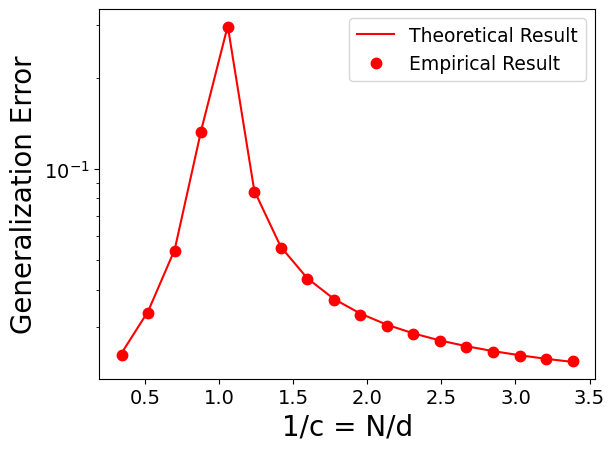

In [ ]:
path_figures = F"/content/drive/My Drive/Denoising/figures/"

device = 'cpu'
M = 3072
N = torch.arange(1050,10500,550).to(torch.int).cpu()
#N_theory = torch.arange(500,6010,55).to(torch.int)

Cinverse = (N/M).cpu().numpy()
#Cinverse_theory = (N_theory/M).cpu().numpy()
# Err_emp_iid_both = torch.load(path2_new_new+"iid-both-emp.pt",map_location = device).numpy()
# Err_iid_both = torch.load(path1_figures+"iid-both.pt",map_location = device).numpy()

plt.plot(Cinverse,Err_svhn[0,:].cpu().numpy(),color="red")
plt.plot(Cinverse,Err_emp_svhn[0,:].cpu().numpy(),'.',markersize = 15,color="red")

plt.yscale("log")
plt.xlabel("1/c = N/d")
plt.ylabel("Generalization Error")
plt.legend(['Theoretical Result','Empirical Result'],fontsize=13.5)
#plt.title('CIFAR Dataset')
plt.savefig(path_figures+"non-identical-svhn-error.pdf", bbox_inches='tight', facecolor='white', dpi = 300, format = 'pdf')

In [ ]:
N = torch.arange(1050,3250,550).to(torch.int)
print(N)

tensor([1050, 1600, 2150, 2700], device='cuda:0', dtype=torch.int32)
tensor([ 3250,  3800,  4350,  4900,  5450,  6000,  6550,  7100,  7650,  8200,
         8750,  9300,  9850, 10400], device='cuda:0', dtype=torch.int32)


In [ ]:
 from numpy.lib.arraysetops import setxor1d
## Low SNR error 

M = 3072
N = torch.arange(1050,10500,550).to(torch.int)
#r_values = [1,2,3,5,10,20,50,100,150,200,250]
#r_values = [50]
#r_values = N
# N = torch.arange(500,1000,500)
# r_values = [1,100]
Ntst = 2500

# Err_stl10 = torch.zeros(len(r_values),N.shape[0]).to(device) #theoretical error
# Err_emp_stl10 = torch.zeros(len(r_values),N.shape[0]).to(device) #empirical error 

# Err_svhn = torch.zeros(len(r_values),N.shape[0]).to(device) #theoretical error
# Err_emp_svhn = torch.zeros(len(r_values),N.shape[0]).to(device) #empirical error 

# Err_cifar = torch.zeros(len(r_values),N.shape[0]).to(device) #theoretical error
# Err_emp_cifar = torch.zeros(len(r_values),N.shape[0]).to(device) #empirical error 
# print(Err_stl10.shape)


Err_stl10 = torch.zeros(1,N.shape[0]).to(device) #theoretical error
Err_emp_stl10 = torch.zeros(1,N.shape[0]).to(device) #empirical error 

Err_svhn = torch.zeros(1,N.shape[0]).to(device) #theoretical error
Err_emp_svhn = torch.zeros(1,N.shape[0]).to(device) #empirical error 

Err_cifar = torch.zeros(1,N.shape[0]).to(device) #theoretical error
Err_emp_cifar = torch.zeros(1,N.shape[0]).to(device) #empirical error 
print(Err_stl10.shape)

# bias = torch.zeros(len(r_values),N.shape[0])
# var = torch.zeros(len(r_values),N.shape[0])

# bias_emp = torch.zeros(len(r_values),N.shape[0])
# var_emp = torch.zeros(len(r_values),N.shape[0])

T = 200 #Number of runs

# for i,r in list(enumerate(r_values)):
#   print(r)

i = 0

for j in range(N.shape[0]):
    r = min(M,N[j])
    print("r=",r)
    c = M/N[j]
    
    cifar_data = torch.utils.data.DataLoader(cifar_train, batch_size = N[j].item(), shuffle = False)
    Xtrn = next(iter(cifar_data))[0].T

    cifar_test_data = torch.utils.data.DataLoader(cifar_test, batch_size = Ntst, shuffle = False)
    Xtst_cifar = next(iter(cifar_test_data))[0].T

    stl10_data = torch.utils.data.DataLoader(stl10_train, batch_size = Ntst, shuffle = False)
    Xtst_stl10 = next(iter(stl10_data))[0].T

    svhn_data = torch.utils.data.DataLoader(svhn_train, batch_size = Ntst, shuffle = False)
    Xtst_svhn = next(iter(svhn_data))[0].T

    print(Xtrn.shape, Xtst_cifar.shape)

    print(c)
    U,S,Vh = torch.linalg.svd(Xtrn)
    Xtrn = U[:,:r] @ torch.diag(S[:r]) @ Vh[:r,:]

    P = U[:,:r] @ U[:,:r].T

    Xtst_cifar_proj = P @ Xtst_cifar
    Xtst_stl10_proj = P @ Xtst_stl10
    Xtst_svhn_proj = P @ Xtst_svhn

    L_cifar = U[:,:r].T @ Xtst_cifar
    L_stl10 = U[:,:r].T @ Xtst_stl10
    L_svhn = U[:,:r].T @ Xtst_svhn

    Err_cifar[i,j] = calc_gen_error(M,N[j],c,Ntst,r,S[:r],L_cifar)
    Err_stl10[i,j] = calc_gen_error(M,N[j],c,Ntst,r,S[:r],L_stl10)
    Err_svhn[i,j] = calc_gen_error(M,N[j],c,Ntst,r,S[:r],L_svhn)

    wnorm = calc_wnorm(c,r,S[:r])
    emp_norm = 0
    emp_bias = 0
    bias = (torch.diag(1/(1+S[:r].square())) @ L_cifar).square().sum()
    
    for k in tqdm(range(T)):
        Atrn = torch.randn_like(Xtrn)/np.sqrt(M)
        W = Xtrn.mm(torch.pinverse(Xtrn+Atrn))

        # emp_norm += W.square().sum()/T

        Atst_cifar = torch.randn_like(Xtst_cifar_proj)/np.sqrt(M)
        Yp = W.mm(Xtst_cifar_proj + Atst_cifar)
        Err_emp_cifar[i,j] += (Xtst_cifar_proj - Yp).square().sum()/(T*Ntst)

        # emp_bias += (Xtst_cifar_proj - W @ Xtst_cifar_proj).square().sum()/T

        Atst_stl10 = torch.randn_like(Xtst_stl10_proj)/np.sqrt(M)
        Yp = W.mm(Xtst_stl10_proj + Atst_stl10)
        Err_emp_stl10[i,j] += (Xtst_stl10_proj - Yp).square().sum()/(T*Ntst)

        Atst_svhn = torch.randn_like(Xtst_svhn_proj)/np.sqrt(M)
        Yp = W.mm(Xtst_svhn_proj + Atst_svhn)
        Err_emp_svhn[i,j] += (Xtst_svhn_proj - Yp).square().sum()/(T*Ntst)
    # print(wnorm, bias)
    # print(emp_norm, emp_bias)
    
    print((Err_emp_cifar[i,j]-Err_cifar[i,j]).abs()/Err_emp_cifar[i,j])
    print((Err_emp_stl10[i,j]-Err_stl10[i,j]).abs()/Err_emp_stl10[i,j])
    print((Err_emp_svhn[i,j]-Err_svhn[i,j]).abs()/Err_emp_svhn[i,j])

    # torch.save(Err_emp_cifar,path2+"cifar-emp-highR.pt")
    # torch.save(Err_cifar,path1+"cifar-highR.pt")  
    # torch.save(Err_emp_stl10,path2+"stl10-emp-highR.pt")
    # torch.save(Err_stl10,path1+"stl10-highR.pt")  
    # torch.save(Err_emp_svhn,path2+"svhn-emp-highR.pt")
    # torch.save(Err_svhn,path1+"svhn-highR.pt")   

    torch.save(Err_emp_cifar,path2+"cifar-emp-fullR.pt")
    torch.save(Err_cifar,path1+"cifar-fullR.pt")  
    torch.save(Err_emp_stl10,path2+"stl10-emp-fullR.pt")
    torch.save(Err_stl10,path1+"stl10-fullR.pt")  
    torch.save(Err_emp_svhn,path2+"svhn-emp-fullR.pt")
    torch.save(Err_svhn,path1+"svhn-fullR.pt")  


    
  # Error_stack = torch.cat((Error_stack,Err_cifar[i,:].unsqueeze(0)),0)
  # Error_emp_stack = torch.cat((Error_emp_stack,Err_emp_cifar[i,:].unsqueeze(0)),0)
  
  # torch.save(Error_stack,path1_new_new)
  # torch.save(Error_emp_stack,path2_new_new)    

torch.Size([1, 18])
r= tensor(1050, device='cuda:0', dtype=torch.int32)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3072, 1050]) torch.Size([3072, 2500])
tensor(2.9257, device='cuda:0')


100%|██████████| 200/200 [00:48<00:00,  4.11it/s]


tensor(0.2399, device='cuda:0')
tensor(0.1584, device='cuda:0')
tensor(0.2908, device='cuda:0')
r= tensor(1600, device='cuda:0', dtype=torch.int32)
torch.Size([3072, 1600]) torch.Size([3072, 2500])
tensor(1.9200, device='cuda:0')


100%|██████████| 200/200 [02:12<00:00,  1.51it/s]


tensor(0.3699, device='cuda:0')
tensor(0.2188, device='cuda:0')
tensor(0.4343, device='cuda:0')
r= tensor(2150, device='cuda:0', dtype=torch.int32)
torch.Size([3072, 2150]) torch.Size([3072, 2500])
tensor(1.4288, device='cuda:0')


100%|██████████| 200/200 [05:16<00:00,  1.58s/it]


tensor(0.4972, device='cuda:0')
tensor(0.2772, device='cuda:0')
tensor(0.5675, device='cuda:0')
r= tensor(2700, device='cuda:0', dtype=torch.int32)
torch.Size([3072, 2700]) torch.Size([3072, 2500])
tensor(1.1378, device='cuda:0')


100%|██████████| 200/200 [10:38<00:00,  3.19s/it]


tensor(0.6170, device='cuda:0')
tensor(0.3359, device='cuda:0')
tensor(0.6889, device='cuda:0')
r= 3072
torch.Size([3072, 3250]) torch.Size([3072, 2500])
tensor(0.9452, device='cuda:0')


100%|██████████| 200/200 [13:38<00:00,  4.09s/it]


tensor(0.6422, device='cuda:0')
tensor(0.3514, device='cuda:0')
tensor(0.7065, device='cuda:0')
r= 3072
torch.Size([3072, 3800]) torch.Size([3072, 2500])
tensor(0.8084, device='cuda:0')


100%|██████████| 200/200 [13:50<00:00,  4.15s/it]


tensor(0.5353, device='cuda:0')
tensor(0.3168, device='cuda:0')
tensor(0.5812, device='cuda:0')
r= 3072
torch.Size([3072, 4350]) torch.Size([3072, 2500])
tensor(0.7062, device='cuda:0')


100%|██████████| 200/200 [14:00<00:00,  4.20s/it]


tensor(0.4532, device='cuda:0')
tensor(0.2799, device='cuda:0')
tensor(0.4881, device='cuda:0')
r= 3072
torch.Size([3072, 4900]) torch.Size([3072, 2500])
tensor(0.6269, device='cuda:0')


100%|██████████| 200/200 [14:09<00:00,  4.25s/it]


tensor(0.3922, device='cuda:0')
tensor(0.2493, device='cuda:0')
tensor(0.4200, device='cuda:0')
r= 3072
torch.Size([3072, 5450]) torch.Size([3072, 2500])
tensor(0.5637, device='cuda:0')


100%|██████████| 200/200 [14:13<00:00,  4.27s/it]


tensor(0.3471, device='cuda:0')
tensor(0.2265, device='cuda:0')
tensor(0.3704, device='cuda:0')
r= 3072
torch.Size([3072, 6000]) torch.Size([3072, 2500])
tensor(0.5120, device='cuda:0')


100%|██████████| 200/200 [14:22<00:00,  4.31s/it]


tensor(0.3101, device='cuda:0')
tensor(0.2057, device='cuda:0')
tensor(0.3297, device='cuda:0')
r= 3072
torch.Size([3072, 6550]) torch.Size([3072, 2500])
tensor(0.4690, device='cuda:0')


100%|██████████| 200/200 [14:28<00:00,  4.34s/it]


tensor(0.2814, device='cuda:0')
tensor(0.1894, device='cuda:0')
tensor(0.2984, device='cuda:0')
r= 3072
torch.Size([3072, 7100]) torch.Size([3072, 2500])
tensor(0.4327, device='cuda:0')


100%|██████████| 200/200 [14:32<00:00,  4.36s/it]


tensor(0.2574, device='cuda:0')
tensor(0.1755, device='cuda:0')
tensor(0.2725, device='cuda:0')
r= 3072
torch.Size([3072, 7650]) torch.Size([3072, 2500])
tensor(0.4016, device='cuda:0')


100%|██████████| 200/200 [14:39<00:00,  4.40s/it]


tensor(0.2370, device='cuda:0')
tensor(0.1632, device='cuda:0')
tensor(0.2504, device='cuda:0')
r= 3072
torch.Size([3072, 8200]) torch.Size([3072, 2500])
tensor(0.3746, device='cuda:0')


100%|██████████| 200/200 [14:47<00:00,  4.44s/it]


tensor(0.2193, device='cuda:0')
tensor(0.1519, device='cuda:0')
tensor(0.2312, device='cuda:0')
r= 3072
torch.Size([3072, 8750]) torch.Size([3072, 2500])
tensor(0.3511, device='cuda:0')


100%|██████████| 200/200 [14:51<00:00,  4.46s/it]


tensor(0.2040, device='cuda:0')
tensor(0.1422, device='cuda:0')
tensor(0.2149, device='cuda:0')
r= 3072
torch.Size([3072, 9300]) torch.Size([3072, 2500])
tensor(0.3303, device='cuda:0')


100%|██████████| 200/200 [14:55<00:00,  4.48s/it]


tensor(0.1907, device='cuda:0')
tensor(0.1339, device='cuda:0')
tensor(0.2009, device='cuda:0')
r= 3072
torch.Size([3072, 9850]) torch.Size([3072, 2500])
tensor(0.3119, device='cuda:0')


100%|██████████| 200/200 [15:03<00:00,  4.52s/it]


tensor(0.1792, device='cuda:0')
tensor(0.1263, device='cuda:0')
tensor(0.1884, device='cuda:0')
r= 3072
torch.Size([3072, 10400]) torch.Size([3072, 2500])
tensor(0.2954, device='cuda:0')


100%|██████████| 200/200 [15:10<00:00,  4.55s/it]


tensor(0.1688, device='cuda:0')
tensor(0.1195, device='cuda:0')
tensor(0.1773, device='cuda:0')


In [ ]:
path_figures = F"/content/drive/My Drive/Denoising/figures/"

device = 'cpu'
M = 3072
N = torch.arange(1050,10500,550).to(torch.int).cpu()
#N_theory = torch.arange(500,6010,55).to(torch.int)

Cinverse = (N/M).cpu().numpy()
#Cinverse_theory = (N_theory/M).cpu().numpy()
Err_emp_cifar_fullR = torch.load(path2+"cifar-emp-fullR.pt",map_location = device).numpy()
Err_cifar_fullR = torch.load(path1+"cifar-fullR.pt",map_location = device).numpy()

plt.plot(Cinverse,Err_cifar_fullR[0,:],color="green")
plt.plot(Cinverse,Err_emp_cifar_fullR[0,:],'.',markersize = 15,color="green")

plt.yscale("log")
plt.xlabel("1/c = N/d")
plt.ylabel("Generalization Error")
plt.legend(['Theoretical Result','Empirical Result'],fontsize=13.5)
#plt.title('CIFAR Dataset')
plt.savefig(path_figures+"cifar-error-fullR.pdf", bbox_inches='tight', facecolor='white', dpi = 300, format = 'pdf')

In [ ]:
path_figures = F"/content/drive/My Drive/Denoising/figures/"

device = 'cpu'
M = 3072
N = torch.arange(1050,10500,550).to(torch.int).cpu()
#N_theory = torch.arange(500,6010,55).to(torch.int)

Cinverse = (N/M).cpu().numpy()
#Cinverse_theory = (N_theory/M).cpu().numpy()
Err_emp_stl10_fullR = torch.load(path2+"stl10-emp-fullR.pt",map_location = device).numpy()
Err_stl10_fullR = torch.load(path1+"stl10-fullR.pt",map_location = device).numpy()

plt.plot(Cinverse,Err_stl10_fullR[0,:],color="blue")
plt.plot(Cinverse,Err_emp_stl10_fullR[0,:],'.',markersize = 15,color="blue")

plt.yscale("log")
plt.xlabel("1/c = N/d")
plt.ylabel("Generalization Error")
plt.legend(['Theoretical Result','Empirical Result'],fontsize=13.5)
#plt.title('CIFAR Dataset')
plt.savefig(path_figures+"stl10-error-fullR.pdf", bbox_inches='tight', facecolor='white', dpi = 300, format = 'pdf')

In [ ]:
path_figures = F"/content/drive/My Drive/Denoising/figures/"

device = 'cpu'
M = 3072
N = torch.arange(1050,10500,550).to(torch.int).cpu()
#N_theory = torch.arange(500,6010,55).to(torch.int)

Cinverse = (N/M).cpu().numpy()
#Cinverse_theory = (N_theory/M).cpu().numpy()
Err_emp_svhn_fullR = torch.load(path2+"svhn-emp-fullR.pt",map_location = device).numpy()
Err_svhn_fullR = torch.load(path1+"svhn-fullR.pt",map_location = device).numpy()

plt.plot(Cinverse,Err_svhn_fullR[0,:],color="red")
plt.plot(Cinverse,Err_emp_svhn_fullR[0,:],'.',markersize = 15,color="red")

plt.yscale("log")
plt.xlabel("1/c = N/d")
plt.ylabel("Generalization Error")
plt.legend(['Theoretical Result','Empirical Result'],fontsize=13.5)
#plt.title('CIFAR Dataset')
plt.savefig(path_figures+"svhn-error-fullR.pdf", bbox_inches='tight', facecolor='white', dpi = 300, format = 'pdf')